# Project 4
______

In [278]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTEN

## COVID Hospitalization

**Binary classification model tuning**

In [144]:
df_surv_hosp=pd.read_csv('../data/clean_data/covid_surveillance_hospitalization.csv')

In [145]:
df_surv_hosp.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No
1,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No
2,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,Yes,No
3,2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No
4,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,Yes,No


In [78]:
#Dropping 'symptom_status' column
# df_surv_hosp.drop(columns=['symptom_status'], inplace=True)

In [177]:
df_surv_hosp.shape

(80538, 10)

In [80]:
#Dropping death_yn column
# df_surv_hosp.drop(columns=['death_yn'], inplace=True)

In [147]:
#converting case_month to DateTime
df_surv_hosp['case_month']=pd.to_datetime(df_surv_hosp['case_month'])

#setting case_month as index
# df_surv_hosp.set_index('case_month', inplace=True)

# sorting index
# df_surv_hosp.sort_index(inplace=True)

In [148]:
df_surv_hosp['month']=df_surv_hosp['case_month'].dt.month

In [149]:
df_surv_hosp.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn,month
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,3
1,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,3
2,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,Yes,No,3
3,2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,No,No,3
4,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,Yes,No,3


**Training model for predicitng hospitalization**

In [150]:
#binarizing target variable - hosp_yn
df_surv_hosp['hosp_yn']=df_surv_hosp['hosp_yn'].map(lambda x: 1 if x=='Yes' else 0)

In [151]:
df_surv_hosp.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn,month
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
1,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
2,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No,3
3,2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
4,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No,3


All our columns will be treated as categorical. Converting month column to object type.

In [152]:
df_surv_hosp['month']=df_surv_hosp['month'].astype(object)

In [190]:
df_surv_hosp_y=df_surv_hosp[df_surv_hosp['hosp_yn']==1].copy()
df_surv_hosp_y.shape

(5765, 10)

In [188]:
df_surv_hosp_y['ethnicity'].value_counts()

Non-Hispanic/Latino    5403
Hispanic/Latino         362
Name: ethnicity, dtype: int64

**Baseline model**

In [175]:
df_surv_hosp['hosp_yn'].value_counts(normalize=True)

0    0.928419
1    0.071581
Name: hosp_yn, dtype: float64

We have highly imbalanced classes for our target variable.  
Our baseline accuracy is 93%

In [154]:
#Creating X and y
X=df_surv_hosp.drop(columns=['case_month','symptom_status','death_yn','hosp_yn'])
y=df_surv_hosp['hosp_yn']
features=list(X.columns)

In [113]:
X.shape, y.shape

((100445, 6), (100445,))

In [114]:
X.head()

,res_state,age_group,sex,race,ethnicity,month
0,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,3
1,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,3
2,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,3
3,PA,65+ years,Female,White,Non-Hispanic/Latino,3
4,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,3


In [115]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: hosp_yn, dtype: int64

In [155]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y, random_state=42)

In [156]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((60403, 6), (60403,), (20135, 6), (20135,))

**One hot encoding train and test**

Defining function to transform train and test sets:

In [157]:
def transform_train(df):
    
       
    #getting list of columns without dropping as a guide for reference:
    col_wo_drop=pd.get_dummies(df)
    dropped_col_guide=col_wo_drop.columns

    #dummyfying columns:
    df_dum=pd.get_dummies(data=df, drop_first=True)   
    
    
    #saving list of dummy columns
    df_dummies = [col for col in df_dum if "_" in col and col.rsplit("_",1)[0] in features]
    
    return ( dropped_col_guide, df_dum, df_dummies)

In [158]:
def transform_test(df, df_dummies):
    #dummyfying columns:
    df_dum=pd.get_dummies(data=df, drop_first=True)   
    
    #Removing additional dummy columns
    for col in df_dum.columns:
        if ("_" in col) and (col.rsplit("_",1)[0] in features) and col not in df_dummies:
            print("Removing additional feature {}".format(col))
            df_dum.drop(col, axis=1, inplace=True)
            
    #Adding missing columns        
    for col in df_dummies:
        if col not in df_dum.columns:
            print("Adding missing feature {}".format(col))
            df_dum[col] = 0
    
    return df_dum

In [159]:
dropped_col_guide, X_train_dum, X_train_dummies=transform_train(X_train)

C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [125]:
X_train_dum.head()

,res_state_AL,res_state_AR,res_state_AZ,res_state_CA,res_state_CO,res_state_CT,res_state_DC,res_state_FL,res_state_GA,res_state_IA,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
27506,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
88468,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
39531,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59187,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
76558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
X_test_dum=transform_test(X_test, X_train_dummies)

Adding missing feature res_state_GA
Adding missing feature res_state_MO


C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [161]:
X_train_dum.shape, X_test_dum.shape

((60403, 62), (20135, 62))

In [162]:
X_test_dum=X_test_dum[X_train_dummies]

In [ ]:
X_train_dum.info()

**Model 1: Logistic Regression**

In [163]:
logreg=LogisticRegression(random_state=42,n_jobs=-1)

# logreg_param={ 
    # 'logreg__
# }

In [164]:
logreg.fit(X_train_dum, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [268]:
eval_df=pd.DataFrame(columns=['model_no', 'comment', 'training_accuracy', 'testing_accuracy', 'f1score_train', 'f1score_test', 'balanced_accuracy', 'recall', 'precision'])

In [269]:
def model_eval(model, model_no, X_train, y_train, X_test, y_test, comment):
    
    
    ConfusionMatrixDisplay.from_estimator(model,X_test, y_test, cmap='Blues')
        
    print(f'Model: {model}')
    #Calculating accuracy score
    training_accuracy=model.score(X_train, y_train)
    print(f'Training_accuracy: {training_accuracy}')
    testing_accuracy=model.score(X_test, y_test)
    print(f'Testing accuracy: {testing_accuracy}')

    #Calculating F1 scores
    pred_train=model.predict(X_train)
    pred=model.predict(X_test)
    f1score_train=f1_score(y_train,pred_train)
    f1score_test=f1_score(y_test,pred)
    print(f'F1 Train score: {f1score_train}')
    print(f'F1 Test score: {f1score_test}')
    
    balanced_accuracy=balanced_accuracy_score(y_test, pred)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    
    recall=recall_score(y_test, pred, pos_label = 1)
    print(f'recall: {recall}')
    
    precision=precision_score(y_test, pred, pos_label = 1)
    print(f'precision: {precision}')
    
    eval_df.loc[len(eval_df.index)]=[ model_no, comment, training_accuracy, testing_accuracy, f1score_train, f1score_test, balanced_accuracy, recall, precision]
    eval_df.to_csv('../data/covid_demo_model_evaluation')
    
    return

Model: LogisticRegression(n_jobs=-1, random_state=42)
Training_accuracy: 0.933447014221148
Testing accuracy: 0.933051899677179
F1 Train score: 0.1914722445695897
F1 Test score: 0.18697225572979492
Balanced Accuracy: 0.552123809685733
recall: 0.10756419153365718
precision: 0.7142857142857143


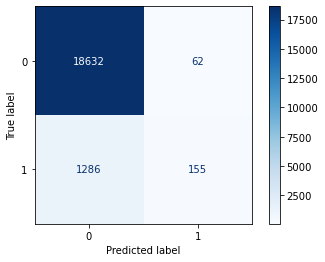

In [270]:
model_eval(logreg, 1, X_train_dum, y_train, X_test_dum, y_test, 'logistic regression')

**Model 2: Undesampling majority class- Logistic Regression**

In [211]:
#Help from lesson 7.06
rus=RandomUnderSampler(random_state=42)

X_train_rus,y_train_rus=rus.fit_resample(X_train_dum,y_train)

In [212]:
X_train_rus.shape, y_train_rus.shape

((8648, 62), (8648,))

In [213]:
logreg_under=LogisticRegression(solver='liblinear')

logreg_under.fit(X_train_rus,y_train_rus)

LogisticRegression(solver='liblinear')

Model: LogisticRegression(solver='liblinear')
Training_accuracy: 0.7654949121184089
Testing accuracy: 0.7606158430593494
F1 Train score: 0.7644052044609665
F1 Test score: 0.31319464234824734
Balanced Accuracy: 0.7615613585153553
recall: 0.7626648160999306
precision: 0.19705935090550475


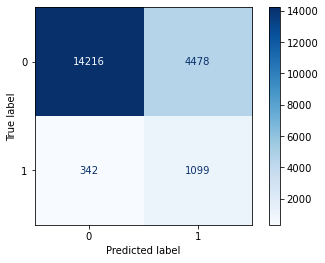

In [271]:
model_eval(logreg_under, 2, X_train_rus, y_train_rus, X_test_dum, y_test, 'logistic regression with undersampling')

Teh F1-score seemed to improve a lot with undersampling

**Model 3: ADASYN-Logistic Regression**

In [231]:
pipe=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('logreg', LogisticRegression(n_jobs=-1))
])

logreg_ada_param={
    'ada__sampling_strategy':[0.5,.75,1]}
   

gs_ada=GridSearchCV(pipe,
               param_grid=logreg_ada_param,
                scoring='balanced_accuracy',
               cv=5)

In [233]:
gs_ada.fit(X_train_dum, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1]},
             scoring='balanced_accuracy')

Model: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1]},
             scoring='balanced_accuracy')
Training_accuracy: 0.7596391106876303
Testing accuracy: 0.7595467178141375
F1 Train score: 0.3216530088984968
F1 Test score: 0.3185053380782918
Balanced Accuracy: 0.7595467178141375
recall: 0.7453157529493407
precision: 0.20252687158212332


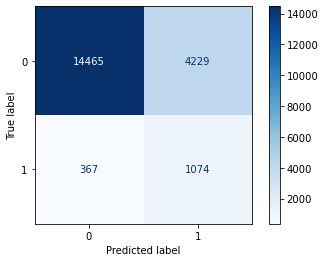

In [272]:
model_eval(gs_ada, 3, X_train_dum, y_train, X_test_dum, y_test, 'logistic regression with ADASYN')

**Model 4: ADASYN-Logistic Regression without GridSearch**

In [238]:
ada2=ADASYN(random_state=42)
X_train_ada,y_train_ada=ada2.fit_resample(X=X_train_dum, y=y_train)

In [239]:
logreg_ada=LogisticRegression(solver='liblinear')

logreg_ada.fit(X_train_ada,y_train_ada)

LogisticRegression(solver='liblinear')

Model: LogisticRegression(solver='liblinear')
Training_accuracy: 0.7758065231861548
Testing accuracy: 0.7714924261236653
F1 Train score: 0.7759377688684684
F1 Test score: 0.3182693732404801
Balanced Accuracy: 0.7594129850656621
recall: 0.7453157529493407
precision: 0.20233609645817635


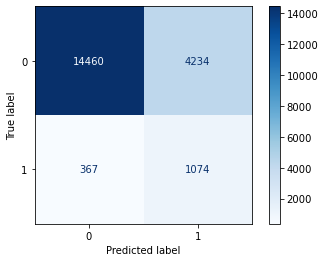

In [273]:
model_eval(logreg_ada, 4, X_train_ada, y_train_ada, X_test_dum, y_test, 'logistic regression with ADASYN2')

**Random Forest**

In [258]:
pipe=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

rf_param={
    'ada__sampling_strategy':[0.5,.75,1],
     'rf__n_estimators': [100,200],
    'rf__max_depth':[None,3,4,5],
    'rf__max_features':['sqrt', 0.8, 0.9],
    'rf__min_samples_split':[2,3]}
   

gs_rf=GridSearchCV(pipe,
                   param_grid=rf_param,
                    scoring='balanced_accuracy',
                   cv=5)

In [259]:
gs_rf.fit(X_train_dum,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1],
                         'rf__max_depth': [None, 3, 4, 5],
                         'rf__max_features': ['sqrt', 0.8, 0.9],
                         'rf__min_samples_split': [2, 3],
                         'rf__n_estimators': [100, 200]},
             scoring='balanced_accuracy')

Model: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1],
                         'rf__max_depth': [None, 3, 4, 5],
                         'rf__max_features': ['sqrt', 0.8, 0.9],
                         'rf__min_samples_split': [2, 3],
                         'rf__n_estimators': [100, 200]},
             scoring='balanced_accuracy')
Training_accuracy: 0.791651123475392
Testing accuracy: 0.7616459414625867
F1 Train score: 0.33990028558981555
F1 Test score: 0.31539460395325347
Balanced Accuracy: 0.7616459414625867
recall: 0.758501040943789
precision: 0.19908925318761383


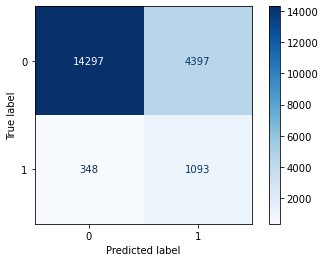

In [274]:
model_eval(gs_rf, 4, X_train_dum, y_train, X_test_dum, y_test, 'Random Forest with ADASYN2')

**Model 4: KNeighbors with SMOTEN**  
Since the features are all categorical, trying SMOTEN

In [279]:
pipe=Pipeline([
    ('sm', SMOTEN(random_state=42)),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_param={
     'knn__n_neighbors':[5,10,15],
     'knn__weights': ['uniform','distance'], 
     'knn__p':[1,2]}
   

gs_knn=GridSearchCV(pipe,
                   param_grid=knn_param,
                    scoring='balanced_accuracy',
                   cv=5)

In [ ]:
gs_knn.fit(X_train_dum,y_train)

C:\Users\deepi\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:731: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(X_class[nn_indices[samples_indices]], axis=1).mode, axis=1
C:\Users\deepi\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:731: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer 